In [8]:
import numpy as np
import pandas as pd

import torchvision
from tqdm import tqdm
import torch.optim as optim

from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
from src.data import CIFAR10_dataset
from src.basic import (
    show_random_images,
    get_device,
    set_seed,
    is_cuda,
    show_model_summary,
    show_img_grid,
    show_random_images_for_each_class
)
from src.model import Net
from src.training import train
from src.testing import test

## albumenation

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
       shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=45, interpolation=1, 
        border_mode=4, p=0.5
    ),
    A.CoarseDropout(
        max_holes=8, max_height=8, 
        max_width=8, p=0.5
    ),
    A.RandomBrightnessContrast(p=0.2),
    A.ToGray(p=0.1),
    A.Normalize(
        mean=(0.491, 0.482, 0.447), 
        std=(0.247, 0.243, 0.262),
        always_apply=True
    ),
    ToTensorV2(),
])

### Device

In [5]:
set_seed()
cuda = is_cuda()
device = get_device()

[INFO] seed set 1
[INFO] Cuda Avaliable :  True
[INFO] device :  cuda


## Data Loader

In [6]:
train_loader = CIFAR10_dataset(
    train=True, cuda=cuda
).get_loader()
test_loader = CIFAR10_dataset(
    train=False, cuda=cuda
).get_loader()

100%|██████████| 170498071/170498071 [10:24<00:00, 273040.24it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
[INFO] train dataset of size 50000 loaded...
Files already downloaded and verified
[INFO] test dataset of size 10000 loaded...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


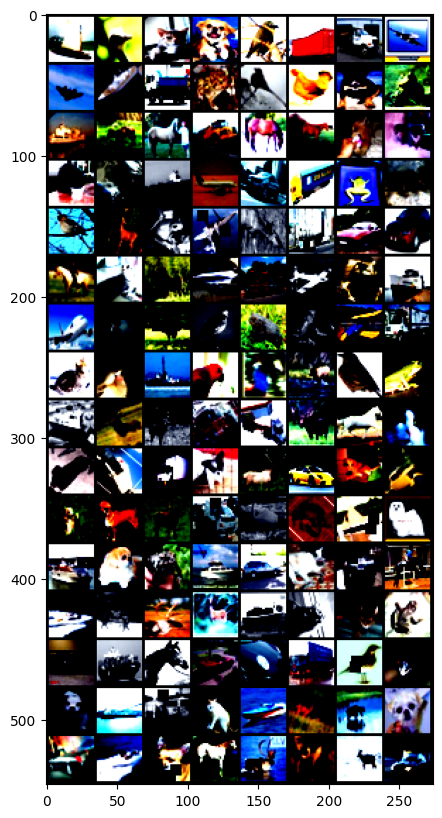

In [7]:
show_random_images(train_loader)

In [9]:
sample_batch = next(iter(train_loader))[0]
sample_img_grid = torchvision.utils.make_grid(sample_batch)
sample_batch.shape[1:]

torch.Size([3, 32, 32])

## Load Model

In [10]:
results = {}
models = {}

In [11]:
experiments= {
    "first_exp": {
        'BN': True, 'dropout_value': 0.2,
        'GN': False, 'LN': False, 'L1': False, 'L2': False
    },
}
EPOCHS = 500

In [13]:
net = Net().to(device)
show_model_summary(net, input_size=sample_batch.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
         ConvBNAct-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           4,608
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
           Dropout-9           [-1, 32, 32, 32]               0
        ConvBNAct-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
          Dropout-14           [-1, 32,

In [15]:
for exp_name, exp in experiments.items():
    print("Experiment : ", exp_name)
    results[exp_name] = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'epoch': [],
    }

    net = Net().to(device)
    # show_model_summary(net, input_size=sample_batch.shape[1:])

    weight_decay = 1e-5 if exp['L2'] else 0
    optimizer = optim.SGD(
        net.parameters(), 
        lr=0.015, momentum=0.9, 
        weight_decay=weight_decay
    )
    lr_scheduler = ReduceLROnPlateau(
        optimizer, mode='min', factor=0.2, 
        patience=3, min_lr=0.0001, verbose=True
    )

    for epoch in range(0, EPOCHS + 1):
        print(f"[EPOCH {epoch} / {EPOCHS}] -- ")
        train_loss_batch, train_acc_batch = train(
            net, device, 
            train_loader, 
            optimizer, 
            lr_scheduler,
            L1=exp['L1']
        )
        
        train_acc = np.mean(train_acc_batch)
        train_loss = np.mean(train_loss_batch)

        test_loss, test_acc = test(
            net, device, 
            test_loader,
            lr_scheduler
        )
        
        for metric in ['train_loss', 'train_acc', 'test_loss', 'test_acc', 'epoch']:
            results[exp_name][metric].append(eval(metric))
    
    models[exp_name] = net


Experiment :  first_exp
[EPOCH 0 / 500] -- 


Loss=1.3207123279571533 Batch_id=390 Accuracy=35.30: 100%|██████████| 391/391 [00:05<00:00, 77.30it/s]



Test set: Average loss: 1.3443, Accuracy: 5084/10000 (50.84%)

[EPOCH 1 / 500] -- 


Loss=1.2853931188583374 Batch_id=390 Accuracy=52.38: 100%|██████████| 391/391 [00:04<00:00, 78.88it/s]



Test set: Average loss: 1.0803, Accuracy: 6123/10000 (61.23%)

[EPOCH 2 / 500] -- 


Loss=1.0417242050170898 Batch_id=390 Accuracy=59.18: 100%|██████████| 391/391 [00:04<00:00, 83.88it/s]



Test set: Average loss: 0.9867, Accuracy: 6458/10000 (64.58%)

[EPOCH 3 / 500] -- 


Loss=0.9968701601028442 Batch_id=390 Accuracy=63.34: 100%|██████████| 391/391 [00:04<00:00, 83.40it/s]



Test set: Average loss: 0.8408, Accuracy: 7016/10000 (70.16%)

[EPOCH 4 / 500] -- 


Loss=1.077504277229309 Batch_id=390 Accuracy=66.13: 100%|██████████| 391/391 [00:04<00:00, 83.03it/s] 



Test set: Average loss: 0.7837, Accuracy: 7259/10000 (72.59%)

[EPOCH 5 / 500] -- 


Loss=0.8637312650680542 Batch_id=390 Accuracy=68.14: 100%|██████████| 391/391 [00:04<00:00, 83.17it/s]



Test set: Average loss: 0.7313, Accuracy: 7515/10000 (75.15%)

[EPOCH 6 / 500] -- 


Loss=1.0306001901626587 Batch_id=390 Accuracy=69.86: 100%|██████████| 391/391 [00:04<00:00, 84.07it/s]



Test set: Average loss: 0.6932, Accuracy: 7619/10000 (76.19%)

[EPOCH 7 / 500] -- 


Loss=0.7758067846298218 Batch_id=390 Accuracy=71.01: 100%|██████████| 391/391 [00:04<00:00, 83.37it/s]



Test set: Average loss: 0.6515, Accuracy: 7783/10000 (77.83%)

[EPOCH 8 / 500] -- 


Loss=0.9020959138870239 Batch_id=390 Accuracy=72.09: 100%|██████████| 391/391 [00:04<00:00, 82.51it/s]



Test set: Average loss: 0.6768, Accuracy: 7681/10000 (76.81%)

[EPOCH 9 / 500] -- 


Loss=1.0162169933319092 Batch_id=390 Accuracy=72.82: 100%|██████████| 391/391 [00:04<00:00, 83.00it/s]



Test set: Average loss: 0.6133, Accuracy: 7914/10000 (79.14%)

[EPOCH 10 / 500] -- 


Loss=0.748054563999176 Batch_id=390 Accuracy=73.63: 100%|██████████| 391/391 [00:04<00:00, 83.48it/s] 



Test set: Average loss: 0.6051, Accuracy: 7947/10000 (79.47%)

[EPOCH 11 / 500] -- 


Loss=0.9159272909164429 Batch_id=390 Accuracy=74.28: 100%|██████████| 391/391 [00:04<00:00, 83.90it/s]



Test set: Average loss: 0.5789, Accuracy: 8004/10000 (80.04%)

[EPOCH 12 / 500] -- 


Loss=0.5156766176223755 Batch_id=390 Accuracy=75.08: 100%|██████████| 391/391 [00:04<00:00, 79.29it/s] 



Test set: Average loss: 0.5803, Accuracy: 7997/10000 (79.97%)

[EPOCH 13 / 500] -- 


Loss=0.6670233607292175 Batch_id=390 Accuracy=75.39: 100%|██████████| 391/391 [00:04<00:00, 80.58it/s]



Test set: Average loss: 0.5578, Accuracy: 8095/10000 (80.95%)

[EPOCH 14 / 500] -- 


Loss=0.7006272077560425 Batch_id=390 Accuracy=76.18: 100%|██████████| 391/391 [00:04<00:00, 83.39it/s]



Test set: Average loss: 0.5377, Accuracy: 8173/10000 (81.73%)

[EPOCH 15 / 500] -- 


Loss=0.6860339045524597 Batch_id=390 Accuracy=76.21: 100%|██████████| 391/391 [00:04<00:00, 82.46it/s]



Test set: Average loss: 0.5300, Accuracy: 8207/10000 (82.07%)

[EPOCH 16 / 500] -- 


Loss=0.6135636568069458 Batch_id=390 Accuracy=76.68: 100%|██████████| 391/391 [00:04<00:00, 82.85it/s] 



Test set: Average loss: 0.5296, Accuracy: 8185/10000 (81.85%)

[EPOCH 17 / 500] -- 


Loss=0.5513498187065125 Batch_id=390 Accuracy=77.23: 100%|██████████| 391/391 [00:04<00:00, 83.12it/s] 



Test set: Average loss: 0.5033, Accuracy: 8268/10000 (82.68%)

[EPOCH 18 / 500] -- 


Loss=0.6427517533302307 Batch_id=390 Accuracy=77.18: 100%|██████████| 391/391 [00:04<00:00, 83.01it/s] 



Test set: Average loss: 0.5119, Accuracy: 8213/10000 (82.13%)

[EPOCH 19 / 500] -- 


Loss=0.8997960090637207 Batch_id=390 Accuracy=77.69: 100%|██████████| 391/391 [00:04<00:00, 82.89it/s] 



Test set: Average loss: 0.5162, Accuracy: 8238/10000 (82.38%)

[EPOCH 20 / 500] -- 


Loss=0.5644708871841431 Batch_id=390 Accuracy=78.06: 100%|██████████| 391/391 [00:04<00:00, 83.36it/s] 



Test set: Average loss: 0.5196, Accuracy: 8252/10000 (82.52%)

[EPOCH 21 / 500] -- 


Loss=0.6182335019111633 Batch_id=390 Accuracy=78.59: 100%|██████████| 391/391 [00:04<00:00, 82.44it/s] 



Test set: Average loss: 0.4784, Accuracy: 8377/10000 (83.77%)

[EPOCH 22 / 500] -- 


Loss=0.578813910484314 Batch_id=390 Accuracy=78.70: 100%|██████████| 391/391 [00:04<00:00, 83.14it/s]  



Test set: Average loss: 0.4775, Accuracy: 8359/10000 (83.59%)

[EPOCH 23 / 500] -- 


Loss=0.7510254383087158 Batch_id=390 Accuracy=78.62: 100%|██████████| 391/391 [00:04<00:00, 81.93it/s] 



Test set: Average loss: 0.4813, Accuracy: 8377/10000 (83.77%)

[EPOCH 24 / 500] -- 


Loss=0.4692223072052002 Batch_id=390 Accuracy=79.02: 100%|██████████| 391/391 [00:05<00:00, 75.69it/s] 



Test set: Average loss: 0.4669, Accuracy: 8425/10000 (84.25%)

[EPOCH 25 / 500] -- 


Loss=0.7917323708534241 Batch_id=390 Accuracy=78.83: 100%|██████████| 391/391 [00:04<00:00, 82.47it/s] 



Test set: Average loss: 0.4540, Accuracy: 8465/10000 (84.65%)

[EPOCH 26 / 500] -- 


Loss=0.6875564455986023 Batch_id=390 Accuracy=79.18: 100%|██████████| 391/391 [00:04<00:00, 82.21it/s] 



Test set: Average loss: 0.4592, Accuracy: 8450/10000 (84.50%)

[EPOCH 27 / 500] -- 


Loss=0.5249005556106567 Batch_id=390 Accuracy=79.36: 100%|██████████| 391/391 [00:04<00:00, 83.07it/s] 



Test set: Average loss: 0.4648, Accuracy: 8405/10000 (84.05%)

[EPOCH 28 / 500] -- 


Loss=0.7161415815353394 Batch_id=390 Accuracy=79.67: 100%|██████████| 391/391 [00:04<00:00, 82.89it/s] 



Test set: Average loss: 0.4532, Accuracy: 8469/10000 (84.69%)

[EPOCH 29 / 500] -- 


Loss=0.5811477899551392 Batch_id=390 Accuracy=80.30: 100%|██████████| 391/391 [00:04<00:00, 83.21it/s] 



Test set: Average loss: 0.4561, Accuracy: 8483/10000 (84.83%)

[EPOCH 30 / 500] -- 


Loss=0.5885212421417236 Batch_id=390 Accuracy=79.85: 100%|██████████| 391/391 [00:04<00:00, 81.44it/s] 



Test set: Average loss: 0.4406, Accuracy: 8502/10000 (85.02%)

[EPOCH 31 / 500] -- 


Loss=0.5924274921417236 Batch_id=390 Accuracy=80.19: 100%|██████████| 391/391 [00:04<00:00, 82.28it/s] 



Test set: Average loss: 0.4484, Accuracy: 8512/10000 (85.12%)

[EPOCH 32 / 500] -- 


Loss=0.5108029246330261 Batch_id=390 Accuracy=80.02: 100%|██████████| 391/391 [00:04<00:00, 82.69it/s] 



Test set: Average loss: 0.4459, Accuracy: 8493/10000 (84.93%)

[EPOCH 33 / 500] -- 


Loss=0.6718841195106506 Batch_id=390 Accuracy=80.40: 100%|██████████| 391/391 [00:04<00:00, 83.66it/s] 



Test set: Average loss: 0.4319, Accuracy: 8511/10000 (85.11%)

[EPOCH 34 / 500] -- 


Loss=0.5405740141868591 Batch_id=390 Accuracy=80.49: 100%|██████████| 391/391 [00:04<00:00, 82.60it/s] 



Test set: Average loss: 0.4363, Accuracy: 8501/10000 (85.01%)

[EPOCH 35 / 500] -- 


Loss=0.7155950665473938 Batch_id=390 Accuracy=80.62: 100%|██████████| 391/391 [00:04<00:00, 83.09it/s] 



Test set: Average loss: 0.4364, Accuracy: 8516/10000 (85.16%)

[EPOCH 36 / 500] -- 


Loss=0.8172591924667358 Batch_id=390 Accuracy=80.77: 100%|██████████| 391/391 [00:05<00:00, 75.23it/s] 



Test set: Average loss: 0.4268, Accuracy: 8549/10000 (85.49%)

[EPOCH 37 / 500] -- 


Loss=0.44636306166648865 Batch_id=390 Accuracy=81.04: 100%|██████████| 391/391 [00:04<00:00, 82.14it/s]



Test set: Average loss: 0.4348, Accuracy: 8537/10000 (85.37%)

[EPOCH 38 / 500] -- 


Loss=0.4998369812965393 Batch_id=390 Accuracy=81.04: 100%|██████████| 391/391 [00:04<00:00, 82.80it/s] 



Test set: Average loss: 0.4238, Accuracy: 8576/10000 (85.76%)

[EPOCH 39 / 500] -- 


Loss=0.7283672094345093 Batch_id=390 Accuracy=81.12: 100%|██████████| 391/391 [00:04<00:00, 83.28it/s] 



Test set: Average loss: 0.4312, Accuracy: 8559/10000 (85.59%)

[EPOCH 40 / 500] -- 


Loss=0.747066855430603 Batch_id=390 Accuracy=81.15: 100%|██████████| 391/391 [00:04<00:00, 83.07it/s]  



Test set: Average loss: 0.4220, Accuracy: 8579/10000 (85.79%)

[EPOCH 41 / 500] -- 


Loss=0.5148902535438538 Batch_id=390 Accuracy=81.18: 100%|██████████| 391/391 [00:04<00:00, 82.87it/s] 



Test set: Average loss: 0.4226, Accuracy: 8556/10000 (85.56%)

[EPOCH 42 / 500] -- 


Loss=0.40678077936172485 Batch_id=390 Accuracy=81.39: 100%|██████████| 391/391 [00:04<00:00, 82.75it/s]



Test set: Average loss: 0.4165, Accuracy: 8547/10000 (85.47%)

[EPOCH 43 / 500] -- 


Loss=0.5527458190917969 Batch_id=390 Accuracy=81.57: 100%|██████████| 391/391 [00:04<00:00, 82.57it/s] 



Test set: Average loss: 0.4306, Accuracy: 8543/10000 (85.43%)

[EPOCH 44 / 500] -- 


Loss=0.6327938437461853 Batch_id=390 Accuracy=81.54: 100%|██████████| 391/391 [00:04<00:00, 82.80it/s] 



Test set: Average loss: 0.4256, Accuracy: 8555/10000 (85.55%)

[EPOCH 45 / 500] -- 


Loss=0.5260459780693054 Batch_id=390 Accuracy=81.76: 100%|██████████| 391/391 [00:04<00:00, 82.52it/s] 



Test set: Average loss: 0.4106, Accuracy: 8609/10000 (86.09%)

[EPOCH 46 / 500] -- 


Loss=0.35741057991981506 Batch_id=390 Accuracy=81.74: 100%|██████████| 391/391 [00:04<00:00, 83.29it/s]



Test set: Average loss: 0.4169, Accuracy: 8619/10000 (86.19%)

[EPOCH 47 / 500] -- 


Loss=0.6415085792541504 Batch_id=390 Accuracy=81.85: 100%|██████████| 391/391 [00:04<00:00, 82.37it/s] 



Test set: Average loss: 0.4009, Accuracy: 8610/10000 (86.10%)

[EPOCH 48 / 500] -- 


Loss=0.9190891981124878 Batch_id=390 Accuracy=82.11: 100%|██████████| 391/391 [00:05<00:00, 74.02it/s] 



Test set: Average loss: 0.4277, Accuracy: 8546/10000 (85.46%)

[EPOCH 49 / 500] -- 


Loss=0.5351883769035339 Batch_id=390 Accuracy=82.18: 100%|██████████| 391/391 [00:04<00:00, 81.91it/s] 



Test set: Average loss: 0.4100, Accuracy: 8603/10000 (86.03%)

[EPOCH 50 / 500] -- 


Loss=0.6822664737701416 Batch_id=390 Accuracy=82.24: 100%|██████████| 391/391 [00:04<00:00, 83.28it/s] 



Test set: Average loss: 0.3951, Accuracy: 8662/10000 (86.62%)

[EPOCH 51 / 500] -- 


Loss=0.6159881949424744 Batch_id=390 Accuracy=82.04: 100%|██████████| 391/391 [00:04<00:00, 82.47it/s] 



Test set: Average loss: 0.4116, Accuracy: 8598/10000 (85.98%)

[EPOCH 52 / 500] -- 


Loss=0.5659481287002563 Batch_id=390 Accuracy=82.32: 100%|██████████| 391/391 [00:04<00:00, 81.75it/s] 



Test set: Average loss: 0.4073, Accuracy: 8634/10000 (86.34%)

[EPOCH 53 / 500] -- 


Loss=0.30562373995780945 Batch_id=390 Accuracy=82.44: 100%|██████████| 391/391 [00:04<00:00, 81.79it/s]



Test set: Average loss: 0.4198, Accuracy: 8591/10000 (85.91%)

[EPOCH 54 / 500] -- 


Loss=0.3584265410900116 Batch_id=390 Accuracy=82.37: 100%|██████████| 391/391 [00:04<00:00, 83.43it/s] 


Epoch 00055: reducing learning rate of group 0 to 3.0000e-03.

Test set: Average loss: 0.3999, Accuracy: 8635/10000 (86.35%)

[EPOCH 55 / 500] -- 


Loss=0.659756064414978 Batch_id=390 Accuracy=83.42: 100%|██████████| 391/391 [00:04<00:00, 83.21it/s]  



Test set: Average loss: 0.3742, Accuracy: 8734/10000 (87.34%)

[EPOCH 56 / 500] -- 


Loss=0.6154864430427551 Batch_id=390 Accuracy=83.76: 100%|██████████| 391/391 [00:04<00:00, 83.12it/s] 



Test set: Average loss: 0.3769, Accuracy: 8712/10000 (87.12%)

[EPOCH 57 / 500] -- 


Loss=0.45306429266929626 Batch_id=390 Accuracy=83.87: 100%|██████████| 391/391 [00:04<00:00, 83.39it/s]



Test set: Average loss: 0.3703, Accuracy: 8741/10000 (87.41%)

[EPOCH 58 / 500] -- 


Loss=0.4545122981071472 Batch_id=390 Accuracy=83.96: 100%|██████████| 391/391 [00:04<00:00, 82.32it/s] 



Test set: Average loss: 0.3674, Accuracy: 8753/10000 (87.53%)

[EPOCH 59 / 500] -- 


Loss=0.5269709825515747 Batch_id=390 Accuracy=84.25: 100%|██████████| 391/391 [00:04<00:00, 82.57it/s] 



Test set: Average loss: 0.3654, Accuracy: 8766/10000 (87.66%)

[EPOCH 60 / 500] -- 


Loss=0.41549620032310486 Batch_id=390 Accuracy=84.15: 100%|██████████| 391/391 [00:05<00:00, 76.64it/s]



Test set: Average loss: 0.3644, Accuracy: 8782/10000 (87.82%)

[EPOCH 61 / 500] -- 


Loss=0.45810070633888245 Batch_id=390 Accuracy=84.48: 100%|██████████| 391/391 [00:04<00:00, 83.02it/s]



Test set: Average loss: 0.3652, Accuracy: 8774/10000 (87.74%)

[EPOCH 62 / 500] -- 


Loss=0.32571667432785034 Batch_id=390 Accuracy=84.44: 100%|██████████| 391/391 [00:04<00:00, 81.98it/s]



Test set: Average loss: 0.3651, Accuracy: 8771/10000 (87.71%)

[EPOCH 63 / 500] -- 


Loss=0.293026864528656 Batch_id=390 Accuracy=84.21: 100%|██████████| 391/391 [00:04<00:00, 82.39it/s]  



Test set: Average loss: 0.3645, Accuracy: 8770/10000 (87.70%)

[EPOCH 64 / 500] -- 


Loss=0.5410256385803223 Batch_id=390 Accuracy=84.49: 100%|██████████| 391/391 [00:04<00:00, 82.77it/s] 



Test set: Average loss: 0.3606, Accuracy: 8771/10000 (87.71%)

[EPOCH 65 / 500] -- 


Loss=0.4513360559940338 Batch_id=390 Accuracy=84.33: 100%|██████████| 391/391 [00:04<00:00, 83.72it/s] 



Test set: Average loss: 0.3641, Accuracy: 8758/10000 (87.58%)

[EPOCH 66 / 500] -- 


Loss=0.4269571304321289 Batch_id=390 Accuracy=84.49: 100%|██████████| 391/391 [00:04<00:00, 82.14it/s] 



Test set: Average loss: 0.3643, Accuracy: 8770/10000 (87.70%)

[EPOCH 67 / 500] -- 


Loss=0.5639642477035522 Batch_id=390 Accuracy=84.59: 100%|██████████| 391/391 [00:04<00:00, 82.15it/s] 



Test set: Average loss: 0.3599, Accuracy: 8786/10000 (87.86%)

[EPOCH 68 / 500] -- 


Loss=0.32781916856765747 Batch_id=390 Accuracy=84.27: 100%|██████████| 391/391 [00:04<00:00, 83.05it/s]



Test set: Average loss: 0.3590, Accuracy: 8767/10000 (87.67%)

[EPOCH 69 / 500] -- 


Loss=0.4132169187068939 Batch_id=390 Accuracy=84.43: 100%|██████████| 391/391 [00:04<00:00, 82.49it/s] 



Test set: Average loss: 0.3613, Accuracy: 8770/10000 (87.70%)

[EPOCH 70 / 500] -- 


Loss=0.3881677985191345 Batch_id=390 Accuracy=84.45: 100%|██████████| 391/391 [00:04<00:00, 82.16it/s] 



Test set: Average loss: 0.3581, Accuracy: 8791/10000 (87.91%)

[EPOCH 71 / 500] -- 


Loss=0.5978518724441528 Batch_id=390 Accuracy=84.62: 100%|██████████| 391/391 [00:04<00:00, 80.54it/s] 



Test set: Average loss: 0.3593, Accuracy: 8762/10000 (87.62%)

[EPOCH 72 / 500] -- 


Loss=0.4992809295654297 Batch_id=390 Accuracy=84.59: 100%|██████████| 391/391 [00:04<00:00, 78.49it/s] 



Test set: Average loss: 0.3581, Accuracy: 8777/10000 (87.77%)

[EPOCH 73 / 500] -- 


Loss=0.4094626307487488 Batch_id=390 Accuracy=84.56: 100%|██████████| 391/391 [00:04<00:00, 82.32it/s] 



Test set: Average loss: 0.3606, Accuracy: 8770/10000 (87.70%)

[EPOCH 74 / 500] -- 


Loss=0.45412641763687134 Batch_id=390 Accuracy=84.43: 100%|██████████| 391/391 [00:04<00:00, 83.26it/s]



Test set: Average loss: 0.3554, Accuracy: 8794/10000 (87.94%)

[EPOCH 75 / 500] -- 


Loss=0.3775525987148285 Batch_id=390 Accuracy=84.78: 100%|██████████| 391/391 [00:04<00:00, 82.13it/s] 



Test set: Average loss: 0.3600, Accuracy: 8800/10000 (88.00%)

[EPOCH 76 / 500] -- 


Loss=0.3381141424179077 Batch_id=390 Accuracy=84.73: 100%|██████████| 391/391 [00:04<00:00, 83.34it/s] 



Test set: Average loss: 0.3554, Accuracy: 8806/10000 (88.06%)

[EPOCH 77 / 500] -- 


Loss=0.47227001190185547 Batch_id=390 Accuracy=84.72: 100%|██████████| 391/391 [00:04<00:00, 82.95it/s]



Test set: Average loss: 0.3616, Accuracy: 8771/10000 (87.71%)

[EPOCH 78 / 500] -- 


Loss=0.30389291048049927 Batch_id=390 Accuracy=84.63: 100%|██████████| 391/391 [00:04<00:00, 83.12it/s]


Epoch 00079: reducing learning rate of group 0 to 6.0000e-04.

Test set: Average loss: 0.3606, Accuracy: 8781/10000 (87.81%)

[EPOCH 79 / 500] -- 


Loss=0.6362168192863464 Batch_id=390 Accuracy=84.86: 100%|██████████| 391/391 [00:04<00:00, 83.20it/s] 



Test set: Average loss: 0.3536, Accuracy: 8808/10000 (88.08%)

[EPOCH 80 / 500] -- 


Loss=0.3681948482990265 Batch_id=390 Accuracy=84.78: 100%|██████████| 391/391 [00:04<00:00, 83.42it/s] 



Test set: Average loss: 0.3562, Accuracy: 8816/10000 (88.16%)

[EPOCH 81 / 500] -- 


Loss=0.2912680506706238 Batch_id=390 Accuracy=84.71: 100%|██████████| 391/391 [00:04<00:00, 83.51it/s] 



Test set: Average loss: 0.3553, Accuracy: 8803/10000 (88.03%)

[EPOCH 82 / 500] -- 


Loss=0.5223832130432129 Batch_id=390 Accuracy=85.04: 100%|██████████| 391/391 [00:04<00:00, 83.63it/s] 



Test set: Average loss: 0.3554, Accuracy: 8821/10000 (88.21%)

[EPOCH 83 / 500] -- 


Loss=0.45618969202041626 Batch_id=390 Accuracy=84.95: 100%|██████████| 391/391 [00:04<00:00, 79.76it/s]


Epoch 00084: reducing learning rate of group 0 to 1.2000e-04.

Test set: Average loss: 0.3540, Accuracy: 8812/10000 (88.12%)

[EPOCH 84 / 500] -- 


Loss=0.42858976125717163 Batch_id=390 Accuracy=84.91: 100%|██████████| 391/391 [00:05<00:00, 78.12it/s]



Test set: Average loss: 0.3540, Accuracy: 8822/10000 (88.22%)

[EPOCH 85 / 500] -- 


Loss=0.5342040061950684 Batch_id=390 Accuracy=84.97: 100%|██████████| 391/391 [00:04<00:00, 82.76it/s] 



Test set: Average loss: 0.3547, Accuracy: 8802/10000 (88.02%)

[EPOCH 86 / 500] -- 


Loss=0.4519995152950287 Batch_id=390 Accuracy=85.07: 100%|██████████| 391/391 [00:04<00:00, 83.53it/s] 



Test set: Average loss: 0.3526, Accuracy: 8811/10000 (88.11%)

[EPOCH 87 / 500] -- 


Loss=0.493180513381958 Batch_id=390 Accuracy=85.29: 100%|██████████| 391/391 [00:04<00:00, 83.86it/s]  



Test set: Average loss: 0.3528, Accuracy: 8816/10000 (88.16%)

[EPOCH 88 / 500] -- 


Loss=0.4803762435913086 Batch_id=390 Accuracy=85.15: 100%|██████████| 391/391 [00:04<00:00, 81.97it/s] 



Test set: Average loss: 0.3518, Accuracy: 8815/10000 (88.15%)

[EPOCH 89 / 500] -- 


Loss=0.31348666548728943 Batch_id=390 Accuracy=85.11: 100%|██████████| 391/391 [00:04<00:00, 83.06it/s]



Test set: Average loss: 0.3548, Accuracy: 8800/10000 (88.00%)

[EPOCH 90 / 500] -- 


Loss=0.2742076814174652 Batch_id=390 Accuracy=84.99: 100%|██████████| 391/391 [00:04<00:00, 82.77it/s] 



Test set: Average loss: 0.3515, Accuracy: 8816/10000 (88.16%)

[EPOCH 91 / 500] -- 


Loss=0.3852340579032898 Batch_id=390 Accuracy=85.05: 100%|██████████| 391/391 [00:04<00:00, 83.24it/s] 



Test set: Average loss: 0.3530, Accuracy: 8823/10000 (88.23%)

[EPOCH 92 / 500] -- 


Loss=0.5959380865097046 Batch_id=390 Accuracy=85.29: 100%|██████████| 391/391 [00:04<00:00, 81.92it/s] 



Test set: Average loss: 0.3535, Accuracy: 8814/10000 (88.14%)

[EPOCH 93 / 500] -- 


Loss=0.39983025193214417 Batch_id=390 Accuracy=84.92: 100%|██████████| 391/391 [00:04<00:00, 83.19it/s]



Test set: Average loss: 0.3514, Accuracy: 8825/10000 (88.25%)

[EPOCH 94 / 500] -- 


Loss=0.326850950717926 Batch_id=390 Accuracy=84.76: 100%|██████████| 391/391 [00:04<00:00, 83.27it/s]  



Test set: Average loss: 0.3517, Accuracy: 8814/10000 (88.14%)

[EPOCH 95 / 500] -- 


Loss=0.3346872329711914 Batch_id=390 Accuracy=85.27: 100%|██████████| 391/391 [00:04<00:00, 78.49it/s] 



Test set: Average loss: 0.3521, Accuracy: 8814/10000 (88.14%)

[EPOCH 96 / 500] -- 


Loss=0.38146448135375977 Batch_id=390 Accuracy=85.21: 100%|██████████| 391/391 [00:04<00:00, 82.14it/s]



Test set: Average loss: 0.3523, Accuracy: 8822/10000 (88.22%)

[EPOCH 97 / 500] -- 


Loss=0.6691012382507324 Batch_id=390 Accuracy=85.21: 100%|██████████| 391/391 [00:04<00:00, 83.40it/s] 



Test set: Average loss: 0.3512, Accuracy: 8811/10000 (88.11%)

[EPOCH 98 / 500] -- 


Loss=0.4418485164642334 Batch_id=390 Accuracy=85.28: 100%|██████████| 391/391 [00:04<00:00, 83.34it/s] 



Test set: Average loss: 0.3536, Accuracy: 8819/10000 (88.19%)

[EPOCH 99 / 500] -- 


Loss=0.4587520658969879 Batch_id=390 Accuracy=85.50: 100%|██████████| 391/391 [00:04<00:00, 83.45it/s] 



Test set: Average loss: 0.3517, Accuracy: 8814/10000 (88.14%)

[EPOCH 100 / 500] -- 


Loss=0.42577752470970154 Batch_id=390 Accuracy=85.38: 100%|██████████| 391/391 [00:04<00:00, 83.15it/s]



Test set: Average loss: 0.3531, Accuracy: 8810/10000 (88.10%)

[EPOCH 101 / 500] -- 


Loss=0.43803200125694275 Batch_id=390 Accuracy=85.00: 100%|██████████| 391/391 [00:04<00:00, 82.76it/s]



Test set: Average loss: 0.3504, Accuracy: 8819/10000 (88.19%)

[EPOCH 102 / 500] -- 


Loss=0.3885341286659241 Batch_id=390 Accuracy=85.19: 100%|██████████| 391/391 [00:04<00:00, 82.59it/s] 



Test set: Average loss: 0.3520, Accuracy: 8810/10000 (88.10%)

[EPOCH 103 / 500] -- 


Loss=0.39931395649909973 Batch_id=390 Accuracy=85.17: 100%|██████████| 391/391 [00:04<00:00, 83.51it/s]



Test set: Average loss: 0.3524, Accuracy: 8814/10000 (88.14%)

[EPOCH 104 / 500] -- 


Loss=0.5496417284011841 Batch_id=390 Accuracy=85.10: 100%|██████████| 391/391 [00:04<00:00, 83.11it/s] 



Test set: Average loss: 0.3505, Accuracy: 8807/10000 (88.07%)

[EPOCH 105 / 500] -- 


Loss=0.6048166751861572 Batch_id=390 Accuracy=85.20: 100%|██████████| 391/391 [00:04<00:00, 82.98it/s] 


Epoch 00106: reducing learning rate of group 0 to 1.0000e-04.

Test set: Average loss: 0.3532, Accuracy: 8804/10000 (88.04%)

[EPOCH 106 / 500] -- 


Loss=0.3917616009712219 Batch_id=390 Accuracy=85.06: 100%|██████████| 391/391 [00:04<00:00, 82.85it/s] 



Test set: Average loss: 0.3513, Accuracy: 8809/10000 (88.09%)

[EPOCH 107 / 500] -- 


Loss=0.5377019643783569 Batch_id=390 Accuracy=85.36: 100%|██████████| 391/391 [00:05<00:00, 75.66it/s] 



Test set: Average loss: 0.3530, Accuracy: 8817/10000 (88.17%)

[EPOCH 108 / 500] -- 


Loss=0.40985703468322754 Batch_id=390 Accuracy=84.99: 100%|██████████| 391/391 [00:04<00:00, 83.80it/s]



Test set: Average loss: 0.3518, Accuracy: 8812/10000 (88.12%)

[EPOCH 109 / 500] -- 


Loss=0.5021973252296448 Batch_id=390 Accuracy=85.15: 100%|██████████| 391/391 [00:04<00:00, 81.91it/s] 



Test set: Average loss: 0.3511, Accuracy: 8803/10000 (88.03%)

[EPOCH 110 / 500] -- 


Loss=0.46801310777664185 Batch_id=390 Accuracy=85.21: 100%|██████████| 391/391 [00:04<00:00, 83.44it/s]



Test set: Average loss: 0.3514, Accuracy: 8803/10000 (88.03%)

[EPOCH 111 / 500] -- 


Loss=0.46919625997543335 Batch_id=390 Accuracy=85.20: 100%|██████████| 391/391 [00:04<00:00, 81.88it/s]



Test set: Average loss: 0.3527, Accuracy: 8820/10000 (88.20%)

[EPOCH 112 / 500] -- 


Loss=0.5843113660812378 Batch_id=390 Accuracy=85.09: 100%|██████████| 391/391 [00:04<00:00, 82.26it/s] 



Test set: Average loss: 0.3509, Accuracy: 8815/10000 (88.15%)

[EPOCH 113 / 500] -- 


Loss=0.3241121768951416 Batch_id=390 Accuracy=85.16: 100%|██████████| 391/391 [00:04<00:00, 83.70it/s] 



Test set: Average loss: 0.3523, Accuracy: 8806/10000 (88.06%)

[EPOCH 114 / 500] -- 


Loss=0.34928610920906067 Batch_id=390 Accuracy=85.29: 100%|██████████| 391/391 [00:04<00:00, 82.46it/s]



Test set: Average loss: 0.3516, Accuracy: 8813/10000 (88.13%)

[EPOCH 115 / 500] -- 


Loss=0.3841707706451416 Batch_id=390 Accuracy=85.18: 100%|██████████| 391/391 [00:04<00:00, 82.39it/s] 



Test set: Average loss: 0.3506, Accuracy: 8819/10000 (88.19%)

[EPOCH 116 / 500] -- 


Loss=0.43889012932777405 Batch_id=390 Accuracy=84.93: 100%|██████████| 391/391 [00:04<00:00, 82.33it/s]



Test set: Average loss: 0.3499, Accuracy: 8809/10000 (88.09%)

[EPOCH 117 / 500] -- 


Loss=0.3973366320133209 Batch_id=390 Accuracy=85.28: 100%|██████████| 391/391 [00:04<00:00, 82.93it/s] 



Test set: Average loss: 0.3512, Accuracy: 8820/10000 (88.20%)

[EPOCH 118 / 500] -- 


Loss=0.30453017354011536 Batch_id=390 Accuracy=85.24: 100%|██████████| 391/391 [00:04<00:00, 81.92it/s]



Test set: Average loss: 0.3549, Accuracy: 8797/10000 (87.97%)

[EPOCH 119 / 500] -- 


Loss=0.5329180359840393 Batch_id=390 Accuracy=85.00: 100%|██████████| 391/391 [00:05<00:00, 77.00it/s] 



Test set: Average loss: 0.3532, Accuracy: 8807/10000 (88.07%)

[EPOCH 120 / 500] -- 


Loss=0.4256458282470703 Batch_id=390 Accuracy=85.45: 100%|██████████| 391/391 [00:04<00:00, 83.12it/s] 



Test set: Average loss: 0.3505, Accuracy: 8813/10000 (88.13%)

[EPOCH 121 / 500] -- 


Loss=0.28772562742233276 Batch_id=390 Accuracy=85.25: 100%|██████████| 391/391 [00:04<00:00, 83.16it/s]



Test set: Average loss: 0.3520, Accuracy: 8812/10000 (88.12%)

[EPOCH 122 / 500] -- 


Loss=0.5372523069381714 Batch_id=390 Accuracy=85.12: 100%|██████████| 391/391 [00:04<00:00, 82.69it/s] 



Test set: Average loss: 0.3529, Accuracy: 8826/10000 (88.26%)

[EPOCH 123 / 500] -- 


Loss=0.4359227120876312 Batch_id=390 Accuracy=85.22: 100%|██████████| 391/391 [00:04<00:00, 83.19it/s] 



Test set: Average loss: 0.3521, Accuracy: 8811/10000 (88.11%)

[EPOCH 124 / 500] -- 


Loss=0.22161893546581268 Batch_id=390 Accuracy=85.12: 100%|██████████| 391/391 [00:04<00:00, 82.58it/s]



Test set: Average loss: 0.3527, Accuracy: 8799/10000 (87.99%)

[EPOCH 125 / 500] -- 


Loss=0.5883458852767944 Batch_id=390 Accuracy=85.24: 100%|██████████| 391/391 [00:04<00:00, 82.26it/s] 



Test set: Average loss: 0.3509, Accuracy: 8819/10000 (88.19%)

[EPOCH 126 / 500] -- 


Loss=0.4572417736053467 Batch_id=390 Accuracy=84.95: 100%|██████████| 391/391 [00:04<00:00, 83.59it/s] 



Test set: Average loss: 0.3516, Accuracy: 8817/10000 (88.17%)

[EPOCH 127 / 500] -- 


Loss=0.36253082752227783 Batch_id=390 Accuracy=85.55: 100%|██████████| 391/391 [00:04<00:00, 83.31it/s]



Test set: Average loss: 0.3518, Accuracy: 8812/10000 (88.12%)

[EPOCH 128 / 500] -- 


Loss=0.39747488498687744 Batch_id=390 Accuracy=85.23: 100%|██████████| 391/391 [00:04<00:00, 83.17it/s]



Test set: Average loss: 0.3517, Accuracy: 8826/10000 (88.26%)

[EPOCH 129 / 500] -- 


Loss=0.48021355271339417 Batch_id=390 Accuracy=85.30: 100%|██████████| 391/391 [00:04<00:00, 82.18it/s]



Test set: Average loss: 0.3497, Accuracy: 8830/10000 (88.30%)

[EPOCH 130 / 500] -- 


Loss=0.6281378865242004 Batch_id=390 Accuracy=85.21: 100%|██████████| 391/391 [00:04<00:00, 82.29it/s] 



Test set: Average loss: 0.3515, Accuracy: 8817/10000 (88.17%)

[EPOCH 131 / 500] -- 


Loss=0.5978055000305176 Batch_id=390 Accuracy=85.06: 100%|██████████| 391/391 [00:05<00:00, 77.42it/s] 



Test set: Average loss: 0.3539, Accuracy: 8819/10000 (88.19%)

[EPOCH 132 / 500] -- 


Loss=0.5035839080810547 Batch_id=390 Accuracy=85.41: 100%|██████████| 391/391 [00:04<00:00, 82.06it/s] 



Test set: Average loss: 0.3517, Accuracy: 8813/10000 (88.13%)

[EPOCH 133 / 500] -- 


Loss=0.6087257266044617 Batch_id=390 Accuracy=85.03: 100%|██████████| 391/391 [00:04<00:00, 83.33it/s] 



Test set: Average loss: 0.3533, Accuracy: 8799/10000 (87.99%)

[EPOCH 134 / 500] -- 


Loss=0.46125879883766174 Batch_id=390 Accuracy=85.20: 100%|██████████| 391/391 [00:04<00:00, 81.93it/s]



Test set: Average loss: 0.3500, Accuracy: 8824/10000 (88.24%)

[EPOCH 135 / 500] -- 


Loss=0.3742847740650177 Batch_id=390 Accuracy=84.99: 100%|██████████| 391/391 [00:04<00:00, 82.92it/s] 



Test set: Average loss: 0.3516, Accuracy: 8811/10000 (88.11%)

[EPOCH 136 / 500] -- 


Loss=0.34924694895744324 Batch_id=390 Accuracy=85.24: 100%|██████████| 391/391 [00:04<00:00, 82.19it/s]



Test set: Average loss: 0.3511, Accuracy: 8821/10000 (88.21%)

[EPOCH 137 / 500] -- 


Loss=0.3761216998100281 Batch_id=390 Accuracy=85.02: 100%|██████████| 391/391 [00:04<00:00, 82.61it/s] 



Test set: Average loss: 0.3526, Accuracy: 8811/10000 (88.11%)

[EPOCH 138 / 500] -- 


Loss=0.4929313063621521 Batch_id=390 Accuracy=85.60: 100%|██████████| 391/391 [00:04<00:00, 83.83it/s] 



Test set: Average loss: 0.3523, Accuracy: 8813/10000 (88.13%)

[EPOCH 139 / 500] -- 


Loss=0.428652822971344 Batch_id=390 Accuracy=85.11: 100%|██████████| 391/391 [00:04<00:00, 83.57it/s]  



Test set: Average loss: 0.3523, Accuracy: 8808/10000 (88.08%)

[EPOCH 140 / 500] -- 


Loss=0.3367682695388794 Batch_id=390 Accuracy=85.29: 100%|██████████| 391/391 [00:04<00:00, 82.81it/s] 



Test set: Average loss: 0.3508, Accuracy: 8807/10000 (88.07%)

[EPOCH 141 / 500] -- 


Loss=0.3333457112312317 Batch_id=262 Accuracy=85.37:  67%|██████▋   | 263/391 [00:03<00:01, 81.16it/s] 


KeyboardInterrupt: 